In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dense, Add, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [11]:
base_path = '../../datasets/'
data_dir = os.path.join(base_path, 'to_train')

dataset_path = os.path.join(data_dir, 'preprocessed')
train_path = os.path.join(data_dir, 'training')
valid_path = os.path.join(data_dir, 'validation')
testing_path = os.path.join(data_dir, 'testing')

In [12]:
class_names = []
split_ratio = 0.2
num_files_to_move = 2
validation_file = 2

In [13]:
img_height, img_width = 224, 224
batch_size = 8
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14400 files belonging to 20 classes.
Using 11520 files for training.


In [14]:
validate_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14400 files belonging to 20 classes.
Using 2880 files for validation.


In [7]:
def residual_block(x, filters, stride=1, use_projection=False):
    identity = x

    # First convolution layer in the block
    x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer in the block
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution layer in the block
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # Projection shortcut for identity
    if use_projection:
        identity = Conv2D(filters * 4, kernel_size=(1, 1), strides=stride, padding='valid')(identity)
        identity = BatchNormalization()(identity)

    # Adding the identity (skip connection) to the output
    x = Add()([x, identity])
    x = ReLU()(x)

    return x

In [8]:
def build_resnet101(input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)
    
    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(22):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(x)

    # Fully connected layer
    x = tf.keras.layers.Dropout(.6)(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet101')

    return model

In [9]:
def build_resnet50(input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(5):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(x)

    # Fully connected layer
    x = tf.keras.layers.Dropout(.6)(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet50')

    return model

In [14]:
# Build ResNet-101 model
resnet101 = build_resnet101()

# Display model summary
resnet101.summary()
# tf.keras.utils.plot_model(resnet101)

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']      

In [ ]:
resnet50 = build_resnet50()

resnet50.summary()
# tf.keras.utils.plot_model(resnet50)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_3 (ZeroPadd  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_261 (Conv2D)         (None, 112, 112, 64)         9472      ['zero_padding2d_3[0][0]']    
                                                                                                  
 batch_normalization_261 (B  (None, 112, 112, 64)         256       ['conv2d_261[0][0]']   

In [15]:
resnet101.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet50.compile(optimizer=Adam(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
saveBestModel = tf.keras.callbacks.ModelCheckpoint('../../models/resnet101_best_model',
                                                   monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
saveBestModel50 = tf.keras.callbacks.ModelCheckpoint('../../models/resnet50_best_model',
                                                     monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
epochs = 100

In [17]:
history = resnet101.fit(train_gen,
          epochs=epochs,
          validation_data=validate_gen,
          callbacks=[saveBestModel]
          )

Epoch 1/100


35/35 [==============================] - ETA: 0s - loss: 67.4417 - accuracy: 0.0543
Epoch 1: val_accuracy improved from -inf to 0.06579, saving model to ../../models\resnet101_best_model
INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 175s 4s/step - loss: 67.4417 - accuracy: 0.0543 - val_loss: 15960603740840925113352192.0000 - val_accuracy: 0.0658
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 31.8952 - accuracy: 0.0688
Epoch 2: val_accuracy did not improve from 0.06579
35/35 [==============================] - 100s 3s/step - loss: 31.8952 - accuracy: 0.0688 - val_loss: 19835555676160.0000 - val_accuracy: 0.0526
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 18.5654 - accuracy: 0.0870
Epoch 3: val_accuracy did not improve from 0.06579
35/35 [==============================] - 99s 3s/step - loss: 18.5654 - accuracy: 0.0870 - val_loss: 570200256.0000 - val_accuracy: 0.0658
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 10.8920 - accuracy: 0.1014
Epoch 4: val_accuracy did not improve from 0.06579
35/35 [==============================] - 99s 3s/step - loss: 10.8920 - accuracy: 0.1014 - val_loss: 20658.0996 - val_accu

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 127s 4s/step - loss: 10.4498 - accuracy: 0.1087 - val_loss: 2343.3455 - val_accuracy: 0.0789
Epoch 6/100
35/35 [==============================] - ETA: 0s - loss: 9.2915 - accuracy: 0.1377
Epoch 6: val_accuracy improved from 0.07895 to 0.19737, saving model to ../../models\resnet101_best_model
INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 130s 4s/step - loss: 9.2915 - accuracy: 0.1377 - val_loss: 41383.6562 - val_accuracy: 0.1974
Epoch 7/100
35/35 [==============================] - ETA: 0s - loss: 7.8180 - accuracy: 0.0870
Epoch 7: val_accuracy did not improve from 0.19737
35/35 [==============================] - 101s 3s/step - loss: 7.8180 - accuracy: 0.0870 - val_loss: 1218.7285 - val_accuracy: 0.0921
Epoch 8/100
35/35 [==============================] - ETA: 0s - loss: 5.3654 - accuracy: 0.1304
Epoch 8: val_accuracy did not improve from 0.19737
35/35 [==============================] - 100s 3s/step - loss: 5.3654 - accuracy: 0.1304 - val_loss: 123.7000 - val_accuracy: 0.0921
Epoch 9/100
35/35 [==============================] - ETA: 0s - loss: 4.7033 - accuracy: 0.1232
Epoch 9: val_accuracy did not improve from 0.19737
35/35 [==============================] - 100s 3s/step - loss: 4.7033 - accuracy: 0.1232 - val_loss: 19.5147 - val_accuracy: 0.1447
Epoch 10/100
35/35 [============

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 128s 4s/step - loss: 4.5661 - accuracy: 0.1558 - val_loss: 10.0138 - val_accuracy: 0.2105
Epoch 11/100
35/35 [==============================] - ETA: 0s - loss: 4.9876 - accuracy: 0.1413
Epoch 11: val_accuracy did not improve from 0.21053
35/35 [==============================] - 103s 3s/step - loss: 4.9876 - accuracy: 0.1413 - val_loss: 7.5440 - val_accuracy: 0.0658
Epoch 12/100
35/35 [==============================] - ETA: 0s - loss: 4.1524 - accuracy: 0.1630
Epoch 12: val_accuracy did not improve from 0.21053
35/35 [==============================] - 102s 3s/step - loss: 4.1524 - accuracy: 0.1630 - val_loss: 1021.6902 - val_accuracy: 0.0658
Epoch 13/100
35/35 [==============================] - ETA: 0s - loss: 4.6499 - accuracy: 0.1486
Epoch 13: val_accuracy did not improve from 0.21053
35/35 [==============================] - 103s 3s/step - loss: 4.6499 - accuracy: 0.1486 - val_loss: 457.6080 - val_accuracy: 0.0526
Epoch 14/100
35/35 [==========

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 130s 4s/step - loss: 2.5180 - accuracy: 0.2536 - val_loss: 3.1418 - val_accuracy: 0.2237
Epoch 23/100
35/35 [==============================] - ETA: 0s - loss: 2.5719 - accuracy: 0.2500
Epoch 23: val_accuracy did not improve from 0.22368
35/35 [==============================] - 101s 3s/step - loss: 2.5719 - accuracy: 0.2500 - val_loss: 3.0681 - val_accuracy: 0.2237
Epoch 24/100
35/35 [==============================] - ETA: 0s - loss: 2.4942 - accuracy: 0.2391
Epoch 24: val_accuracy did not improve from 0.22368
35/35 [==============================] - 101s 3s/step - loss: 2.4942 - accuracy: 0.2391 - val_loss: 4.6874 - val_accuracy: 0.1842
Epoch 25/100
35/35 [==============================] - ETA: 0s - loss: 2.4228 - accuracy: 0.2645
Epoch 25: val_accuracy improved from 0.22368 to 0.26316, saving model to ../../models\resnet101_best_model
INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 129s 4s/step - loss: 2.4228 - accuracy: 0.2645 - val_loss: 4.6830 - val_accuracy: 0.2632
Epoch 26/100
35/35 [==============================] - ETA: 0s - loss: 2.4505 - accuracy: 0.2717
Epoch 26: val_accuracy did not improve from 0.26316
35/35 [==============================] - 101s 3s/step - loss: 2.4505 - accuracy: 0.2717 - val_loss: 6.6033 - val_accuracy: 0.1711
Epoch 27/100
35/35 [==============================] - ETA: 0s - loss: 2.7526 - accuracy: 0.2754
Epoch 27: val_accuracy did not improve from 0.26316
35/35 [==============================] - 102s 3s/step - loss: 2.7526 - accuracy: 0.2754 - val_loss: 3.7500 - val_accuracy: 0.2500
Epoch 28/100
35/35 [==============================] - ETA: 0s - loss: 2.3249 - accuracy: 0.2935
Epoch 28: val_accuracy did not improve from 0.26316
35/35 [==============================] - 104s 3s/step - loss: 2.3249 - accuracy: 0.2935 - val_loss: 2.8481 - val_accuracy: 0.2632
Epoch 29/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 141s 4s/step - loss: 2.2822 - accuracy: 0.3333 - val_loss: 2.5655 - val_accuracy: 0.3289
Epoch 30/100
35/35 [==============================] - ETA: 0s - loss: 2.2964 - accuracy: 0.3514
Epoch 30: val_accuracy did not improve from 0.32895
35/35 [==============================] - 104s 3s/step - loss: 2.2964 - accuracy: 0.3514 - val_loss: 2.5482 - val_accuracy: 0.2763
Epoch 31/100
35/35 [==============================] - ETA: 0s - loss: 2.1969 - accuracy: 0.3659
Epoch 31: val_accuracy did not improve from 0.32895
35/35 [==============================] - 102s 3s/step - loss: 2.1969 - accuracy: 0.3659 - val_loss: 2.2776 - val_accuracy: 0.2895
Epoch 32/100
35/35 [==============================] - ETA: 0s - loss: 2.2384 - accuracy: 0.3696
Epoch 32: val_accuracy did not improve from 0.32895
35/35 [==============================] - 102s 3s/step - loss: 2.2384 - accuracy: 0.3696 - val_loss: 2.7560 - val_accuracy: 0.2368
Epoch 33/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 131s 4s/step - loss: 2.1986 - accuracy: 0.3370 - val_loss: 2.1237 - val_accuracy: 0.3684
Epoch 37/100
35/35 [==============================] - ETA: 0s - loss: 2.2052 - accuracy: 0.3442
Epoch 37: val_accuracy improved from 0.36842 to 0.38158, saving model to ../../models\resnet101_best_model
INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 137s 4s/step - loss: 2.2052 - accuracy: 0.3442 - val_loss: 2.0529 - val_accuracy: 0.3816
Epoch 38/100
35/35 [==============================] - ETA: 0s - loss: 2.0488 - accuracy: 0.4239
Epoch 38: val_accuracy improved from 0.38158 to 0.43421, saving model to ../../models\resnet101_best_model
INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 145s 4s/step - loss: 2.0488 - accuracy: 0.4239 - val_loss: 2.1199 - val_accuracy: 0.4342
Epoch 39/100
35/35 [==============================] - ETA: 0s - loss: 2.0586 - accuracy: 0.4094
Epoch 39: val_accuracy did not improve from 0.43421
35/35 [==============================] - 114s 3s/step - loss: 2.0586 - accuracy: 0.4094 - val_loss: 2.1040 - val_accuracy: 0.4342
Epoch 40/100
35/35 [==============================] - ETA: 0s - loss: 1.9253 - accuracy: 0.4493
Epoch 40: val_accuracy did not improve from 0.43421
35/35 [==============================] - 114s 3s/step - loss: 1.9253 - accuracy: 0.4493 - val_loss: 2.4472 - val_accuracy: 0.4079
Epoch 41/100
35/35 [==============================] - ETA: 0s - loss: 2.0594 - accuracy: 0.4094
Epoch 41: val_accuracy did not improve from 0.43421
35/35 [==============================] - 111s 3s/step - loss: 2.0594 - accuracy: 0.4094 - val_loss: 2.4277 - val_accuracy: 0.4079
Epoch 42/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 139s 4s/step - loss: 1.8916 - accuracy: 0.4239 - val_loss: 1.9145 - val_accuracy: 0.4868
Epoch 45/100
35/35 [==============================] - ETA: 0s - loss: 2.0106 - accuracy: 0.4203
Epoch 45: val_accuracy did not improve from 0.48684
35/35 [==============================] - 105s 3s/step - loss: 2.0106 - accuracy: 0.4203 - val_loss: 2.2352 - val_accuracy: 0.3947
Epoch 46/100
35/35 [==============================] - ETA: 0s - loss: 1.8874 - accuracy: 0.4457
Epoch 46: val_accuracy did not improve from 0.48684
35/35 [==============================] - 106s 3s/step - loss: 1.8874 - accuracy: 0.4457 - val_loss: 2.3976 - val_accuracy: 0.4342
Epoch 47/100
35/35 [==============================] - ETA: 0s - loss: 1.7350 - accuracy: 0.4638
Epoch 47: val_accuracy did not improve from 0.48684
35/35 [==============================] - 106s 3s/step - loss: 1.7350 - accuracy: 0.4638 - val_loss: 2.5854 - val_accuracy: 0.3026
Epoch 48/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 136s 4s/step - loss: 1.7848 - accuracy: 0.4783 - val_loss: 1.6451 - val_accuracy: 0.5132
Epoch 50/100
35/35 [==============================] - ETA: 0s - loss: 1.7337 - accuracy: 0.4746
Epoch 50: val_accuracy did not improve from 0.51316
35/35 [==============================] - 112s 3s/step - loss: 1.7337 - accuracy: 0.4746 - val_loss: 2.3115 - val_accuracy: 0.5132
Epoch 51/100
35/35 [==============================] - ETA: 0s - loss: 1.6770 - accuracy: 0.5181
Epoch 51: val_accuracy did not improve from 0.51316
35/35 [==============================] - 113s 3s/step - loss: 1.6770 - accuracy: 0.5181 - val_loss: 1.7286 - val_accuracy: 0.5132
Epoch 52/100
35/35 [==============================] - ETA: 0s - loss: 1.9637 - accuracy: 0.4203
Epoch 52: val_accuracy did not improve from 0.51316
35/35 [==============================] - 112s 3s/step - loss: 1.9637 - accuracy: 0.4203 - val_loss: 1.7882 - val_accuracy: 0.4868
Epoch 53/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 137s 4s/step - loss: 1.5998 - accuracy: 0.5435 - val_loss: 2.0266 - val_accuracy: 0.5526
Epoch 58/100
35/35 [==============================] - ETA: 0s - loss: 1.5701 - accuracy: 0.5072
Epoch 58: val_accuracy did not improve from 0.55263
35/35 [==============================] - 110s 3s/step - loss: 1.5701 - accuracy: 0.5072 - val_loss: 2.1868 - val_accuracy: 0.4605
Epoch 59/100
35/35 [==============================] - ETA: 0s - loss: 1.9990 - accuracy: 0.4710
Epoch 59: val_accuracy did not improve from 0.55263
35/35 [==============================] - 111s 3s/step - loss: 1.9990 - accuracy: 0.4710 - val_loss: 1.7871 - val_accuracy: 0.5132
Epoch 60/100
35/35 [==============================] - ETA: 0s - loss: 1.8552 - accuracy: 0.4348
Epoch 60: val_accuracy did not improve from 0.55263
35/35 [==============================] - 111s 3s/step - loss: 1.8552 - accuracy: 0.4348 - val_loss: 1.6435 - val_accuracy: 0.5395
Epoch 61/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 139s 4s/step - loss: 1.4839 - accuracy: 0.5725 - val_loss: 1.5138 - val_accuracy: 0.5921
Epoch 62/100
35/35 [==============================] - ETA: 0s - loss: 1.6164 - accuracy: 0.5471
Epoch 62: val_accuracy did not improve from 0.59211
35/35 [==============================] - 106s 3s/step - loss: 1.6164 - accuracy: 0.5471 - val_loss: 1.9570 - val_accuracy: 0.4342
Epoch 63/100
35/35 [==============================] - ETA: 0s - loss: 1.6431 - accuracy: 0.5109
Epoch 63: val_accuracy did not improve from 0.59211
35/35 [==============================] - 106s 3s/step - loss: 1.6431 - accuracy: 0.5109 - val_loss: 2.9208 - val_accuracy: 0.4737
Epoch 64/100
35/35 [==============================] - ETA: 0s - loss: 1.3849 - accuracy: 0.5435
Epoch 64: val_accuracy did not improve from 0.59211
35/35 [==============================] - 106s 3s/step - loss: 1.3849 - accuracy: 0.5435 - val_loss: 2.6810 - val_accuracy: 0.5132
Epoch 65/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 134s 4s/step - loss: 1.3911 - accuracy: 0.5725 - val_loss: 1.8574 - val_accuracy: 0.6316
Epoch 75/100
35/35 [==============================] - ETA: 0s - loss: 1.3802 - accuracy: 0.6123
Epoch 75: val_accuracy did not improve from 0.63158
35/35 [==============================] - 105s 3s/step - loss: 1.3802 - accuracy: 0.6123 - val_loss: 2.2053 - val_accuracy: 0.5395
Epoch 76/100
35/35 [==============================] - ETA: 0s - loss: 1.2444 - accuracy: 0.6159
Epoch 76: val_accuracy did not improve from 0.63158
35/35 [==============================] - 106s 3s/step - loss: 1.2444 - accuracy: 0.6159 - val_loss: 2.8939 - val_accuracy: 0.4868
Epoch 77/100
35/35 [==============================] - ETA: 0s - loss: 1.2910 - accuracy: 0.6051
Epoch 77: val_accuracy did not improve from 0.63158
35/35 [==============================] - 106s 3s/step - loss: 1.2910 - accuracy: 0.6051 - val_loss: 1.4766 - val_accuracy: 0.5789
Epoch 78/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 134s 4s/step - loss: 1.3310 - accuracy: 0.6087 - val_loss: 1.5468 - val_accuracy: 0.6842
Epoch 79/100
35/35 [==============================] - ETA: 0s - loss: 1.4821 - accuracy: 0.5616
Epoch 79: val_accuracy did not improve from 0.68421
35/35 [==============================] - 111s 3s/step - loss: 1.4821 - accuracy: 0.5616 - val_loss: 5.9544 - val_accuracy: 0.4211
Epoch 80/100
35/35 [==============================] - ETA: 0s - loss: 1.6180 - accuracy: 0.5435
Epoch 80: val_accuracy did not improve from 0.68421
35/35 [==============================] - 111s 3s/step - loss: 1.6180 - accuracy: 0.5435 - val_loss: 2.3863 - val_accuracy: 0.4342
Epoch 81/100
35/35 [==============================] - ETA: 0s - loss: 1.5502 - accuracy: 0.6051
Epoch 81: val_accuracy did not improve from 0.68421
35/35 [==============================] - 111s 3s/step - loss: 1.5502 - accuracy: 0.6051 - val_loss: 14.7523 - val_accuracy: 0.1842
Epoch 82/100
35/35 [===============

INFO:tensorflow:Assets written to: ../../models\resnet101_best_model\assets


35/35 [==============================] - 157s 5s/step - loss: 1.0718 - accuracy: 0.6449 - val_loss: 1.4871 - val_accuracy: 0.7105
Epoch 98/100
35/35 [==============================] - ETA: 0s - loss: 0.8837 - accuracy: 0.7138
Epoch 98: val_accuracy did not improve from 0.71053
35/35 [==============================] - 118s 3s/step - loss: 0.8837 - accuracy: 0.7138 - val_loss: 1.3996 - val_accuracy: 0.6711
Epoch 99/100
35/35 [==============================] - ETA: 0s - loss: 0.9459 - accuracy: 0.6993
Epoch 99: val_accuracy did not improve from 0.71053
35/35 [==============================] - 119s 3s/step - loss: 0.9459 - accuracy: 0.6993 - val_loss: 2.0020 - val_accuracy: 0.6316
Epoch 100/100
35/35 [==============================] - ETA: 0s - loss: 0.8390 - accuracy: 0.7065
Epoch 100: val_accuracy did not improve from 0.71053
35/35 [==============================] - 122s 4s/step - loss: 0.8390 - accuracy: 0.7065 - val_loss: 2.6433 - val_accuracy: 0.5921


In [ ]:
history_resnet50 = resnet50.fit(
    train_gen,
    epochs=epochs,
    validation_data=validate_gen,
    callbacks=[saveBestModel50]
)

Epoch 1/100


35/35 [==============================] - ETA: 0s - loss: 51.1327 - accuracy: 0.0688
Epoch 1: val_accuracy improved from -inf to 0.06579, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 91s 2s/step - loss: 51.1327 - accuracy: 0.0688 - val_loss: 3805976142544896.0000 - val_accuracy: 0.0658
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 18.9855 - accuracy: 0.0725
Epoch 2: val_accuracy improved from 0.06579 to 0.13158, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 77s 2s/step - loss: 18.9855 - accuracy: 0.0725 - val_loss: 23302268928.0000 - val_accuracy: 0.1316
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 15.3007 - accuracy: 0.1123
Epoch 3: val_accuracy did not improve from 0.13158
35/35 [==============================] - 63s 2s/step - loss: 15.3007 - accuracy: 0.1123 - val_loss: 295524000.0000 - val_accuracy: 0.0526
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 10.9425 - accuracy: 0.0978
Epoch 4: val_accuracy did not improve from 0.13158
35/35 [==============================] - 63s 2s/step - loss: 10.9425 - accuracy: 0.0978 - val_loss: 50731.2383 - val_accuracy: 0.0526
Epoch 5/100
35/35 [==============================] - ETA: 0s - loss: 10.6444 - accuracy: 0.1014
Epoch 5: val_accuracy did not improve from 0.13158
35/35 [==============================] - 63s 2s/step - loss: 10.6444 - accuracy: 0.1014 - val_loss: 2553.1494 - val_accuracy: 0.0789
Epoch 6/100
35

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 76s 2s/step - loss: 6.5739 - accuracy: 0.1812 - val_loss: 329.5566 - val_accuracy: 0.1447
Epoch 8/100
35/35 [==============================] - ETA: 0s - loss: 6.4892 - accuracy: 0.2174
Epoch 8: val_accuracy did not improve from 0.14474
35/35 [==============================] - 62s 2s/step - loss: 6.4892 - accuracy: 0.2174 - val_loss: 149.3119 - val_accuracy: 0.1184
Epoch 9/100
35/35 [==============================] - ETA: 0s - loss: 5.7069 - accuracy: 0.2645
Epoch 9: val_accuracy improved from 0.14474 to 0.19737, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 85s 2s/step - loss: 5.7069 - accuracy: 0.2645 - val_loss: 37.6471 - val_accuracy: 0.1974
Epoch 10/100
35/35 [==============================] - ETA: 0s - loss: 4.6325 - accuracy: 0.2319
Epoch 10: val_accuracy improved from 0.19737 to 0.30263, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 76s 2s/step - loss: 4.6325 - accuracy: 0.2319 - val_loss: 36.4405 - val_accuracy: 0.3026
Epoch 11/100
35/35 [==============================] - ETA: 0s - loss: 5.5847 - accuracy: 0.2681
Epoch 11: val_accuracy improved from 0.30263 to 0.32895, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 76s 2s/step - loss: 5.5847 - accuracy: 0.2681 - val_loss: 20.6448 - val_accuracy: 0.3289
Epoch 12/100
35/35 [==============================] - ETA: 0s - loss: 4.3159 - accuracy: 0.3297
Epoch 12: val_accuracy did not improve from 0.32895
35/35 [==============================] - 64s 2s/step - loss: 4.3159 - accuracy: 0.3297 - val_loss: 22.2592 - val_accuracy: 0.2632
Epoch 13/100
35/35 [==============================] - ETA: 0s - loss: 4.7657 - accuracy: 0.2645
Epoch 13: val_accuracy did not improve from 0.32895
35/35 [==============================] - 65s 2s/step - loss: 4.7657 - accuracy: 0.2645 - val_loss: 4.2352 - val_accuracy: 0.3158
Epoch 14/100
35/35 [==============================] - ETA: 0s - loss: 4.6950 - accuracy: 0.2935
Epoch 14: val_accuracy improved from 0.32895 to 0.36842, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 78s 2s/step - loss: 4.6950 - accuracy: 0.2935 - val_loss: 18.9097 - val_accuracy: 0.3684
Epoch 15/100
35/35 [==============================] - ETA: 0s - loss: 4.4335 - accuracy: 0.2935
Epoch 15: val_accuracy improved from 0.36842 to 0.46053, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 81s 2s/step - loss: 4.4335 - accuracy: 0.2935 - val_loss: 20.2924 - val_accuracy: 0.4605
Epoch 16/100
35/35 [==============================] - ETA: 0s - loss: 3.8150 - accuracy: 0.3913
Epoch 16: val_accuracy did not improve from 0.46053
35/35 [==============================] - 63s 2s/step - loss: 3.8150 - accuracy: 0.3913 - val_loss: 19.8718 - val_accuracy: 0.3684
Epoch 17/100
35/35 [==============================] - ETA: 0s - loss: 3.2870 - accuracy: 0.3152
Epoch 17: val_accuracy did not improve from 0.46053
35/35 [==============================] - 63s 2s/step - loss: 3.2870 - accuracy: 0.3152 - val_loss: 31.3516 - val_accuracy: 0.3553
Epoch 18/100
35/35 [==============================] - ETA: 0s - loss: 3.9498 - accuracy: 0.3659
Epoch 18: val_accuracy did not improve from 0.46053
35/35 [==============================] - 62s 2s/step - loss: 3.9498 - accuracy: 0.3659 - val_loss: 21.4744 - val_accuracy: 0.4079
Epoch 19/100
35/35 [================

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 78s 2s/step - loss: 2.8353 - accuracy: 0.3696 - val_loss: 3.6969 - val_accuracy: 0.5132
Epoch 23/100
35/35 [==============================] - ETA: 0s - loss: 2.8711 - accuracy: 0.3986
Epoch 23: val_accuracy improved from 0.51316 to 0.53947, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 77s 2s/step - loss: 2.8711 - accuracy: 0.3986 - val_loss: 7.2957 - val_accuracy: 0.5395
Epoch 24/100
35/35 [==============================] - ETA: 0s - loss: 2.4576 - accuracy: 0.3986
Epoch 24: val_accuracy did not improve from 0.53947
35/35 [==============================] - 62s 2s/step - loss: 2.4576 - accuracy: 0.3986 - val_loss: 4.6060 - val_accuracy: 0.5132
Epoch 25/100
35/35 [==============================] - ETA: 0s - loss: 2.3860 - accuracy: 0.4239
Epoch 25: val_accuracy did not improve from 0.53947
35/35 [==============================] - 62s 2s/step - loss: 2.3860 - accuracy: 0.4239 - val_loss: 5.8137 - val_accuracy: 0.5000
Epoch 26/100
35/35 [==============================] - ETA: 0s - loss: 2.2841 - accuracy: 0.4239
Epoch 26: val_accuracy improved from 0.53947 to 0.61842, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 76s 2s/step - loss: 2.2841 - accuracy: 0.4239 - val_loss: 3.9220 - val_accuracy: 0.6184
Epoch 27/100
35/35 [==============================] - ETA: 0s - loss: 2.0403 - accuracy: 0.4529
Epoch 27: val_accuracy did not improve from 0.61842
35/35 [==============================] - 62s 2s/step - loss: 2.0403 - accuracy: 0.4529 - val_loss: 2.9207 - val_accuracy: 0.5789
Epoch 28/100
35/35 [==============================] - ETA: 0s - loss: 1.8494 - accuracy: 0.4783
Epoch 28: val_accuracy did not improve from 0.61842
35/35 [==============================] - 62s 2s/step - loss: 1.8494 - accuracy: 0.4783 - val_loss: 4.8526 - val_accuracy: 0.5526
Epoch 29/100
35/35 [==============================] - ETA: 0s - loss: 1.8231 - accuracy: 0.5145
Epoch 29: val_accuracy did not improve from 0.61842
35/35 [==============================] - 63s 2s/step - loss: 1.8231 - accuracy: 0.5145 - val_loss: 2.9317 - val_accuracy: 0.6053
Epoch 30/100
35/35 [====================

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 90s 3s/step - loss: 1.6460 - accuracy: 0.5435 - val_loss: 2.4944 - val_accuracy: 0.6316
Epoch 33/100
35/35 [==============================] - ETA: 0s - loss: 1.6689 - accuracy: 0.5254
Epoch 33: val_accuracy improved from 0.63158 to 0.68421, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 76s 2s/step - loss: 1.6689 - accuracy: 0.5254 - val_loss: 2.3412 - val_accuracy: 0.6842
Epoch 34/100
35/35 [==============================] - ETA: 0s - loss: 1.6508 - accuracy: 0.5507
Epoch 34: val_accuracy did not improve from 0.68421
35/35 [==============================] - 64s 2s/step - loss: 1.6508 - accuracy: 0.5507 - val_loss: 2.6304 - val_accuracy: 0.6184
Epoch 35/100
35/35 [==============================] - ETA: 0s - loss: 1.4068 - accuracy: 0.5870
Epoch 35: val_accuracy did not improve from 0.68421
35/35 [==============================] - 65s 2s/step - loss: 1.4068 - accuracy: 0.5870 - val_loss: 2.5805 - val_accuracy: 0.6184
Epoch 36/100
35/35 [==============================] - ETA: 0s - loss: 1.5024 - accuracy: 0.5761
Epoch 36: val_accuracy did not improve from 0.68421
35/35 [==============================] - 66s 2s/step - loss: 1.5024 - accuracy: 0.5761 - val_loss: 2.2325 - val_accuracy: 0.6711
Epoch 37/100
35/35 [====================

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 80s 2s/step - loss: 1.2471 - accuracy: 0.6232 - val_loss: 1.3524 - val_accuracy: 0.7237
Epoch 42/100
35/35 [==============================] - ETA: 0s - loss: 1.1404 - accuracy: 0.6304
Epoch 42: val_accuracy did not improve from 0.72368
35/35 [==============================] - 66s 2s/step - loss: 1.1404 - accuracy: 0.6304 - val_loss: 1.3119 - val_accuracy: 0.6711
Epoch 43/100
35/35 [==============================] - ETA: 0s - loss: 1.2539 - accuracy: 0.6232
Epoch 43: val_accuracy improved from 0.72368 to 0.73684, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 80s 2s/step - loss: 1.2539 - accuracy: 0.6232 - val_loss: 1.5075 - val_accuracy: 0.7368
Epoch 44/100
35/35 [==============================] - ETA: 0s - loss: 1.2355 - accuracy: 0.6630
Epoch 44: val_accuracy did not improve from 0.73684
35/35 [==============================] - 65s 2s/step - loss: 1.2355 - accuracy: 0.6630 - val_loss: 2.0057 - val_accuracy: 0.6711
Epoch 45/100
35/35 [==============================] - ETA: 0s - loss: 1.0532 - accuracy: 0.6630
Epoch 45: val_accuracy did not improve from 0.73684
35/35 [==============================] - 66s 2s/step - loss: 1.0532 - accuracy: 0.6630 - val_loss: 1.7250 - val_accuracy: 0.6579
Epoch 46/100
35/35 [==============================] - ETA: 0s - loss: 1.1401 - accuracy: 0.6594
Epoch 46: val_accuracy did not improve from 0.73684
35/35 [==============================] - 66s 2s/step - loss: 1.1401 - accuracy: 0.6594 - val_loss: 1.9610 - val_accuracy: 0.6711
Epoch 47/100
35/35 [====================

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 94s 3s/step - loss: 0.9471 - accuracy: 0.6739 - val_loss: 1.4676 - val_accuracy: 0.7500
Epoch 48/100
35/35 [==============================] - ETA: 0s - loss: 1.0912 - accuracy: 0.6957
Epoch 48: val_accuracy did not improve from 0.75000
35/35 [==============================] - 65s 2s/step - loss: 1.0912 - accuracy: 0.6957 - val_loss: 1.9146 - val_accuracy: 0.7368
Epoch 49/100
35/35 [==============================] - ETA: 0s - loss: 0.9173 - accuracy: 0.7029
Epoch 49: val_accuracy improved from 0.75000 to 0.76316, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 81s 2s/step - loss: 0.9173 - accuracy: 0.7029 - val_loss: 1.5088 - val_accuracy: 0.7632
Epoch 50/100
35/35 [==============================] - ETA: 0s - loss: 1.1056 - accuracy: 0.6739
Epoch 50: val_accuracy did not improve from 0.76316
35/35 [==============================] - 68s 2s/step - loss: 1.1056 - accuracy: 0.6739 - val_loss: 3.1974 - val_accuracy: 0.6053
Epoch 51/100
35/35 [==============================] - ETA: 0s - loss: 0.9970 - accuracy: 0.6993
Epoch 51: val_accuracy did not improve from 0.76316
35/35 [==============================] - 65s 2s/step - loss: 0.9970 - accuracy: 0.6993 - val_loss: 1.6177 - val_accuracy: 0.7632
Epoch 52/100
35/35 [==============================] - ETA: 0s - loss: 1.1552 - accuracy: 0.6775
Epoch 52: val_accuracy improved from 0.76316 to 0.77632, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 79s 2s/step - loss: 1.1552 - accuracy: 0.6775 - val_loss: 1.4262 - val_accuracy: 0.7763
Epoch 53/100
35/35 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.6920
Epoch 53: val_accuracy did not improve from 0.77632
35/35 [==============================] - 64s 2s/step - loss: 1.0614 - accuracy: 0.6920 - val_loss: 1.8236 - val_accuracy: 0.6974
Epoch 54/100
35/35 [==============================] - ETA: 0s - loss: 1.0965 - accuracy: 0.6703
Epoch 54: val_accuracy did not improve from 0.77632
35/35 [==============================] - 65s 2s/step - loss: 1.0965 - accuracy: 0.6703 - val_loss: 1.2399 - val_accuracy: 0.7763
Epoch 55/100
35/35 [==============================] - ETA: 0s - loss: 1.1989 - accuracy: 0.6341
Epoch 55: val_accuracy did not improve from 0.77632
35/35 [==============================] - 65s 2s/step - loss: 1.1989 - accuracy: 0.6341 - val_loss: 1.3558 - val_accuracy: 0.7105
Epoch 56/100
35/35 [====================

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 81s 2s/step - loss: 1.1296 - accuracy: 0.6630 - val_loss: 1.1395 - val_accuracy: 0.7895
Epoch 63/100
35/35 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.7500
Epoch 63: val_accuracy did not improve from 0.78947
35/35 [==============================] - 66s 2s/step - loss: 0.7576 - accuracy: 0.7500 - val_loss: 1.2133 - val_accuracy: 0.7368
Epoch 64/100
35/35 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.7754
Epoch 64: val_accuracy did not improve from 0.78947
35/35 [==============================] - 66s 2s/step - loss: 0.7272 - accuracy: 0.7754 - val_loss: 1.5286 - val_accuracy: 0.7500
Epoch 65/100
35/35 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.7609
Epoch 65: val_accuracy did not improve from 0.78947
35/35 [==============================] - 66s 2s/step - loss: 0.7021 - accuracy: 0.7609 - val_loss: 2.0682 - val_accuracy: 0.7368
Epoch 66/100
35/35 [====================

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 80s 2s/step - loss: 0.7292 - accuracy: 0.7428 - val_loss: 0.9734 - val_accuracy: 0.8026
Epoch 89/100
35/35 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7790
Epoch 89: val_accuracy improved from 0.80263 to 0.81579, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 81s 2s/step - loss: 0.6662 - accuracy: 0.7790 - val_loss: 1.0763 - val_accuracy: 0.8158
Epoch 90/100
35/35 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.7572
Epoch 90: val_accuracy did not improve from 0.81579
35/35 [==============================] - 64s 2s/step - loss: 0.7359 - accuracy: 0.7572 - val_loss: 6.2122 - val_accuracy: 0.6184
Epoch 91/100
35/35 [==============================] - ETA: 0s - loss: 0.9209 - accuracy: 0.7572
Epoch 91: val_accuracy did not improve from 0.81579
35/35 [==============================] - 67s 2s/step - loss: 0.9209 - accuracy: 0.7572 - val_loss: 1.6777 - val_accuracy: 0.7763
Epoch 92/100
35/35 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.7681
Epoch 92: val_accuracy did not improve from 0.81579
35/35 [==============================] - 65s 2s/step - loss: 0.7372 - accuracy: 0.7681 - val_loss: 3.5267 - val_accuracy: 0.6447
Epoch 93/100
35/35 [====================

INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 84s 2s/step - loss: 0.7346 - accuracy: 0.7428 - val_loss: 0.8674 - val_accuracy: 0.8421
Epoch 95/100
35/35 [==============================] - ETA: 0s - loss: 0.7495 - accuracy: 0.7862
Epoch 95: val_accuracy improved from 0.84211 to 0.86842, saving model to ../../models\resnet50_best_model
INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


INFO:tensorflow:Assets written to: ../../models\resnet50_best_model\assets


35/35 [==============================] - 83s 2s/step - loss: 0.7495 - accuracy: 0.7862 - val_loss: 0.9715 - val_accuracy: 0.8684
Epoch 96/100
35/35 [==============================] - ETA: 0s - loss: 0.6326 - accuracy: 0.8261
Epoch 96: val_accuracy did not improve from 0.86842
35/35 [==============================] - 69s 2s/step - loss: 0.6326 - accuracy: 0.8261 - val_loss: 2.1060 - val_accuracy: 0.6842
Epoch 97/100
35/35 [==============================] - ETA: 0s - loss: 0.7370 - accuracy: 0.7754
Epoch 97: val_accuracy did not improve from 0.86842
35/35 [==============================] - 67s 2s/step - loss: 0.7370 - accuracy: 0.7754 - val_loss: 0.9016 - val_accuracy: 0.8289
Epoch 98/100
35/35 [==============================] - ETA: 0s - loss: 0.5798 - accuracy: 0.7971
Epoch 98: val_accuracy did not improve from 0.86842
35/35 [==============================] - 67s 2s/step - loss: 0.5798 - accuracy: 0.7971 - val_loss: 1.1060 - val_accuracy: 0.8421
Epoch 99/100
35/35 [====================

In [ ]:
best_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_104 (Conv2D)         (None, 112, 112, 64)         9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_104 (B  (None, 112, 112, 64)         256       ['conv2d_104[0][0]']  

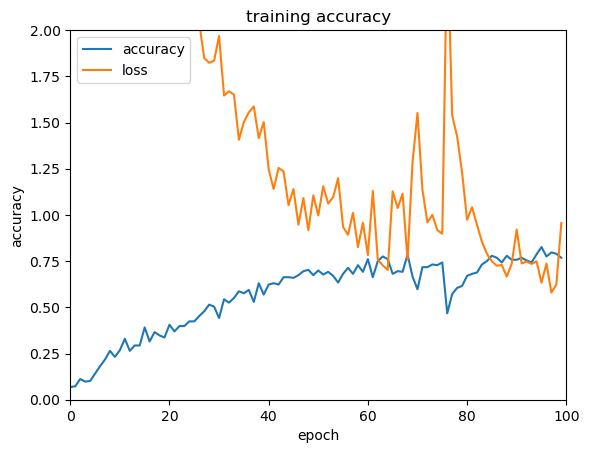

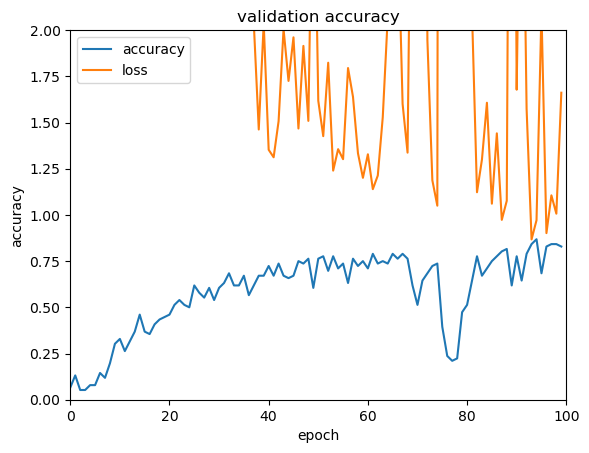

In [47]:
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['loss'])
plt.title('training accuracy')
plt.axis([0, 100, 0, 2])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history_resnet50.history['val_accuracy'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('validation accuracy')
plt.axis([0, 100, 0, 2])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

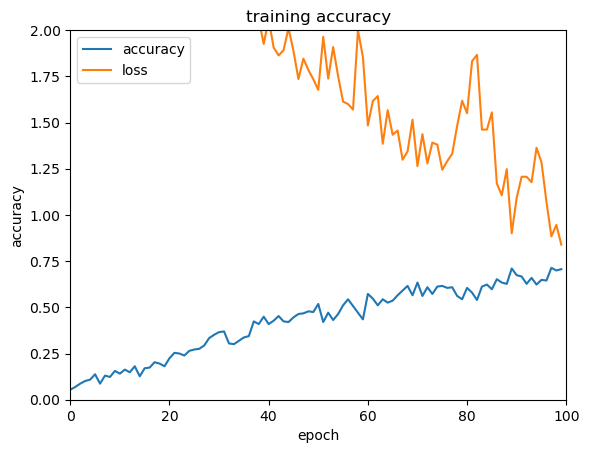

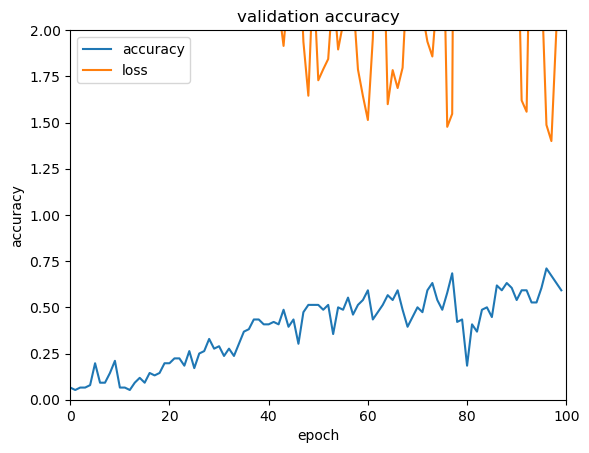

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('training accuracy')
plt.axis([0, 100, 0, 2])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('validation accuracy')
plt.axis([0, 100, 0, 2])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [15]:
model_resnet101 = keras.models.load_model('../../models/resnet101_14000.h5')
model_resnet50 = keras.models.load_model('../../models/resnet50_14000.h5')

In [20]:
import visualkeras

visualkeras.layered_view(model_resnet50).show()


In [21]:
visualkeras.layered_view(model_resnet101).show()

In [16]:
class_names = train_gen.class_names
num_classes = len(class_names)
class_dict = {}
i = 0
for classes in class_names:
   class_dict[classes] = i
   i += 1

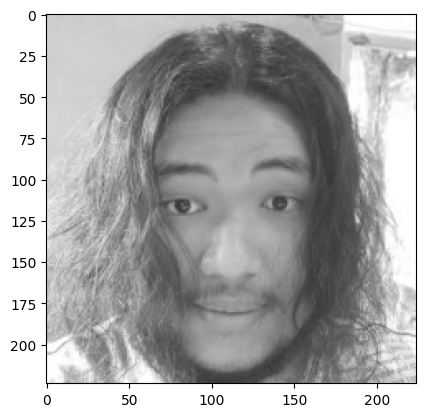

1/1 [==============================] - 0s 151ms/step
Nama File:  2007051040_IMG-20231116-WA0016.jpg
Prediksi 101:  2017051017
Prediksi 50:  2117051070
Probabilitas 101:  0.6561676859855652
Probabilitas 50:  0.7168223261833191




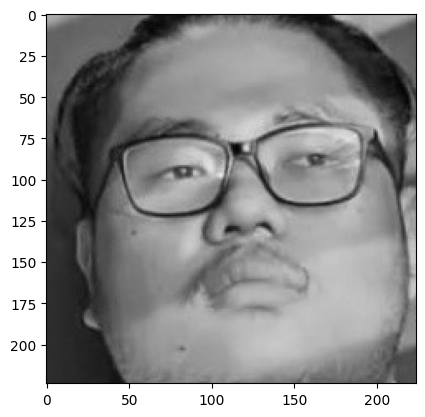

1/1 [==============================] - 0s 144ms/step
Nama File:  2007051040_IMG-20231116-WA0024.jpg
Prediksi 101:  2007051040
Prediksi 50:  2007051040
Probabilitas 101:  0.9592552185058594
Probabilitas 50:  0.9682111144065857




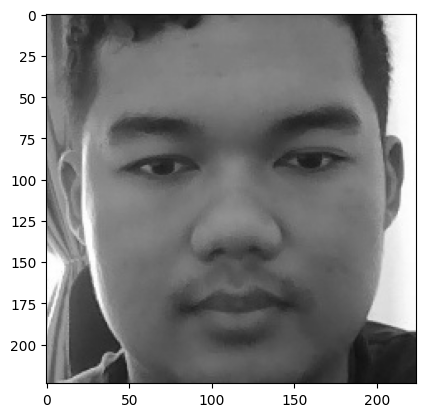

1/1 [==============================] - 0s 177ms/step
Nama File:  2017051001_WIN_20230930_10_53_35_Pro.jpg
Prediksi 101:  2017051001
Prediksi 50:  2017051001
Probabilitas 101:  0.9768088459968567
Probabilitas 50:  0.8726354837417603




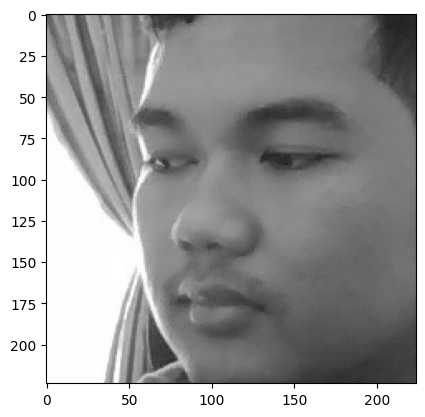

1/1 [==============================] - 0s 153ms/step
Nama File:  2017051001_WIN_20230930_10_53_49_Pro.jpg
Prediksi 101:  2017051001
Prediksi 50:  2017051001
Probabilitas 101:  0.9197624325752258
Probabilitas 50:  0.9464406371116638




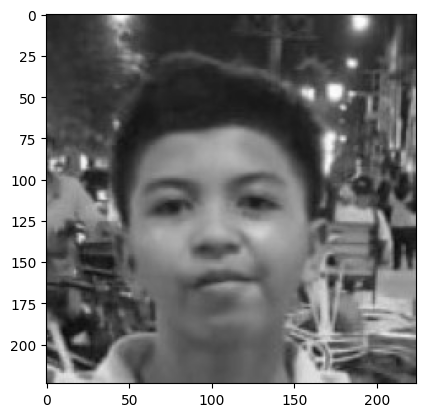

1/1 [==============================] - 0s 136ms/step
Nama File:  2017051006_IMG-20190615-WA0010.jpg
Prediksi 101:  2017051006
Prediksi 50:  2017051078
Probabilitas 101:  0.1782204955816269
Probabilitas 50:  0.32974424958229065




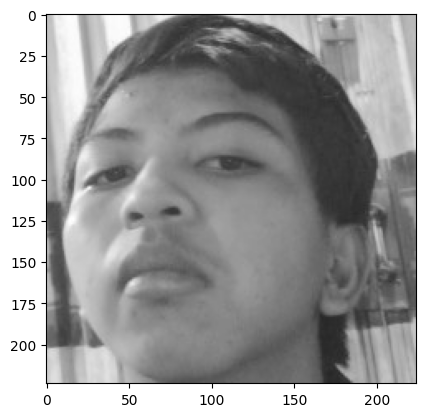

1/1 [==============================] - 0s 152ms/step
Nama File:  2017051006_IMG_20230307_220634_597.jpg
Prediksi 101:  2017051017
Prediksi 50:  2007051040
Probabilitas 101:  0.42806097865104675
Probabilitas 50:  0.24730128049850464




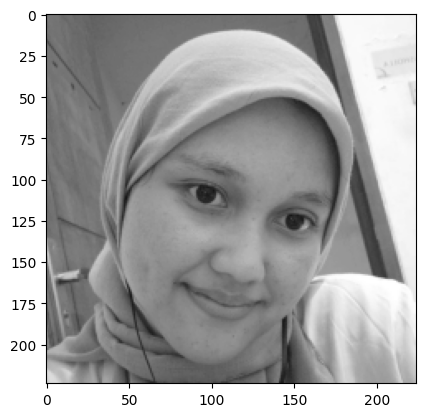

1/1 [==============================] - 0s 130ms/step
Nama File:  2017051017_IMG-20230302-WA0016.png
Prediksi 101:  2017051017
Prediksi 50:  2017051017
Probabilitas 101:  0.36970484256744385
Probabilitas 50:  0.7998546957969666




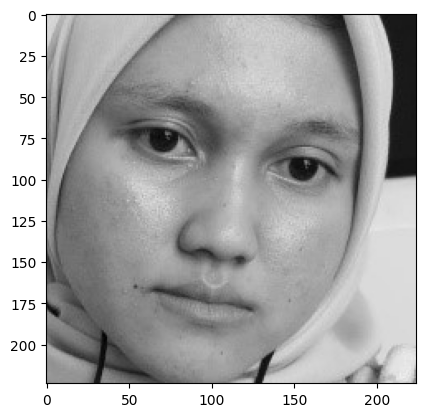

1/1 [==============================] - 0s 133ms/step
Nama File:  2017051017_IMG-20230628-WA0011.jpg
Prediksi 101:  2017051017
Prediksi 50:  2017051017
Probabilitas 101:  0.8764008283615112
Probabilitas 50:  0.684260368347168




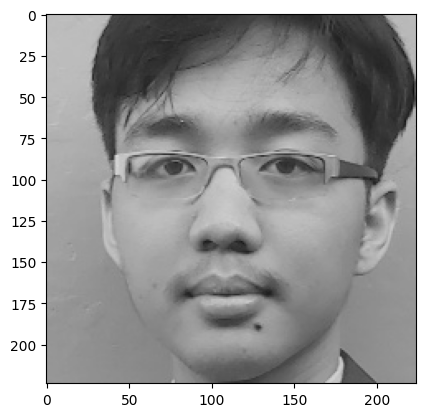

1/1 [==============================] - 0s 151ms/step
Nama File:  2017051049_20220514_171320.jpg
Prediksi 101:  2017051049
Prediksi 50:  2017051049
Probabilitas 101:  0.45181572437286377
Probabilitas 50:  0.6933906078338623




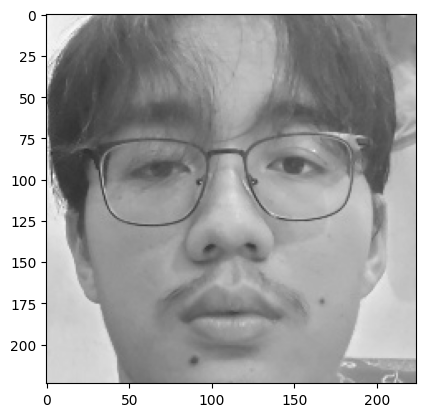

1/1 [==============================] - 0s 140ms/step
Nama File:  2017051049_20220918_220925.jpg
Prediksi 101:  2017051049
Prediksi 50:  2017051049
Probabilitas 101:  0.641154408454895
Probabilitas 50:  0.6706728339195251




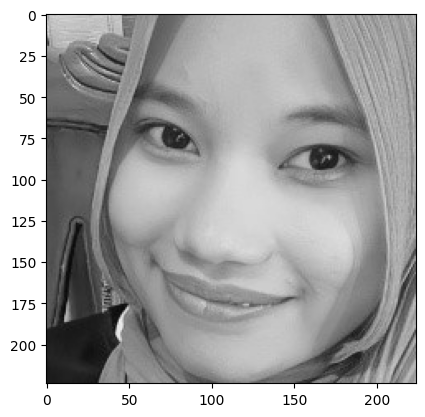

1/1 [==============================] - 0s 137ms/step
Nama File:  2017051051_25215227-3192-4450-b98d-f54f3445ce3b.jpg
Prediksi 101:  2017051051
Prediksi 50:  2017051049
Probabilitas 101:  0.6707950830459595
Probabilitas 50:  0.6168186664581299




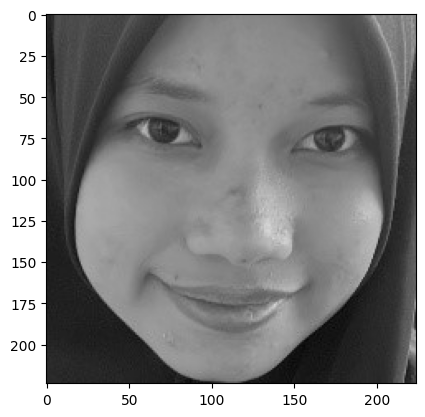

1/1 [==============================] - 0s 137ms/step
Nama File:  2017051051_5FECB4FF-92AB-4561-BCA0-9486C173306A.jpg
Prediksi 101:  2017051051
Prediksi 50:  2017051051
Probabilitas 101:  0.7783066034317017
Probabilitas 50:  0.7950333952903748




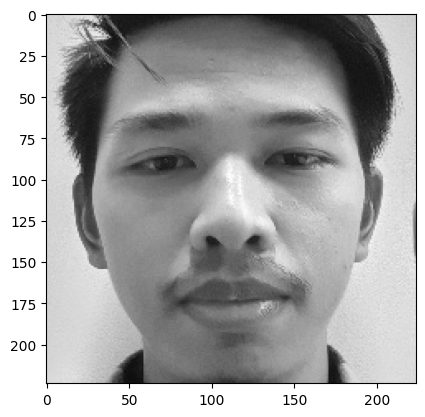

1/1 [==============================] - 0s 135ms/step
Nama File:  2017051055_20230608_075143.jpg
Prediksi 101:  2117051070
Prediksi 50:  2117051070
Probabilitas 101:  0.3590209186077118
Probabilitas 50:  0.23364968597888947




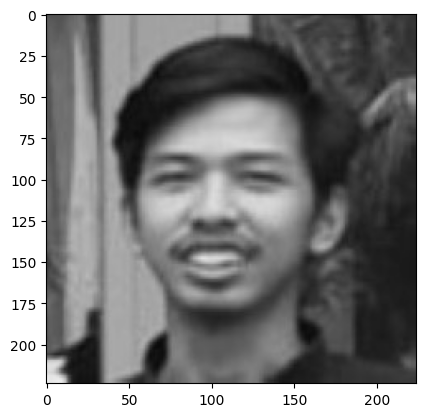

1/1 [==============================] - 0s 130ms/step
Nama File:  2017051055_IMG-20231121-WA0020.jpg
Prediksi 101:  2017051055
Prediksi 50:  2017051055
Probabilitas 101:  0.6622862219810486
Probabilitas 50:  0.6487329006195068




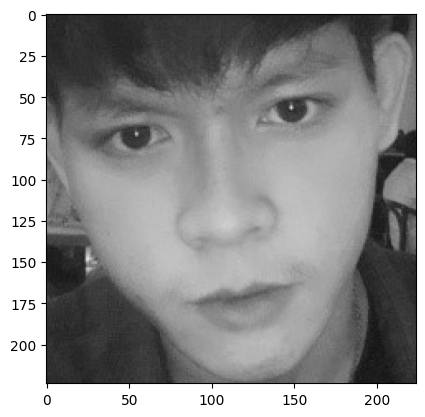

1/1 [==============================] - 0s 129ms/step
Nama File:  2017051061_A8222BA3-AAFE-427F-A1A9-F0114A0FD65C.jpg
Prediksi 101:  2017051061
Prediksi 50:  2017051061
Probabilitas 101:  0.4266224503517151
Probabilitas 50:  0.7549358606338501




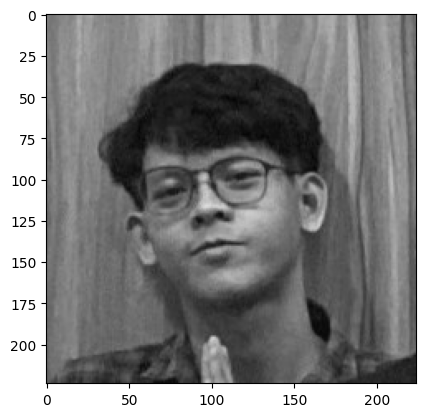

1/1 [==============================] - 0s 132ms/step
Nama File:  2017051061_IMG_0284.jpg
Prediksi 101:  2017051055
Prediksi 50:  2017051055
Probabilitas 101:  0.5928551554679871
Probabilitas 50:  0.6845681667327881




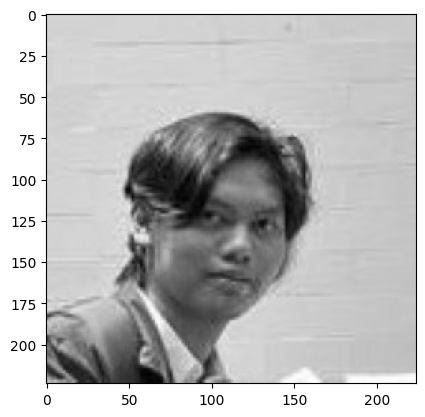

1/1 [==============================] - 0s 137ms/step
Nama File:  2017051078_IMG-20230904-WA0014.jpg
Prediksi 101:  2017051078
Prediksi 50:  2017051078
Probabilitas 101:  0.5473564863204956
Probabilitas 50:  0.5677968263626099




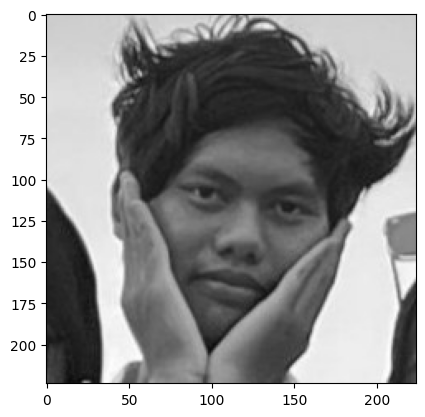

1/1 [==============================] - 0s 142ms/step
Nama File:  2017051078_IMG-20231211-WA0016.jpg
Prediksi 101:  2017051051
Prediksi 50:  2017051051
Probabilitas 101:  0.5006510019302368
Probabilitas 50:  0.7076141238212585




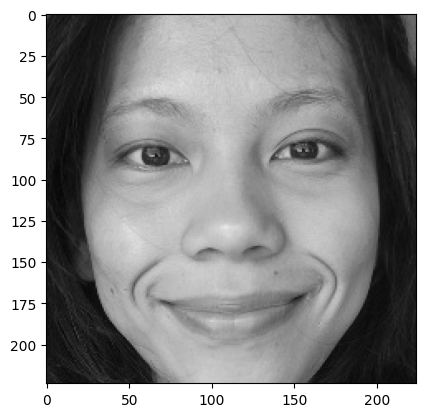

1/1 [==============================] - 0s 151ms/step
Nama File:  2117051009_IMG_20230930_121321_957.jpg
Prediksi 101:  2117051009
Prediksi 50:  2117051009
Probabilitas 101:  0.9997379183769226
Probabilitas 50:  0.9996284246444702




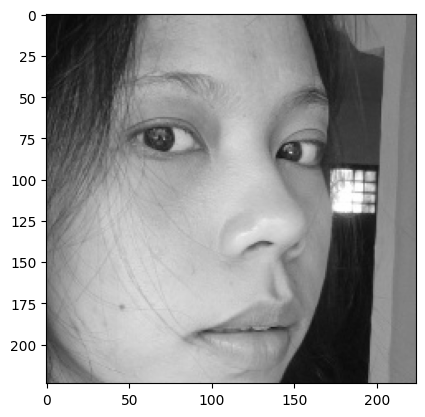

1/1 [==============================] - 0s 135ms/step
Nama File:  2117051009_IMG_20230930_121327_185.jpg
Prediksi 101:  2117051009
Prediksi 50:  2117051009
Probabilitas 101:  0.9225763082504272
Probabilitas 50:  0.25155410170555115




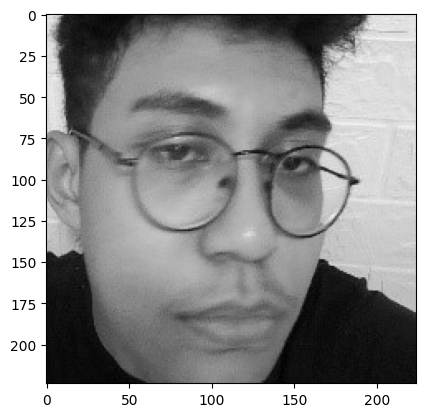

1/1 [==============================] - 0s 153ms/step
Nama File:  2117051019_IMG20231001213540.jpg
Prediksi 101:  2157051006
Prediksi 50:  2157051006
Probabilitas 101:  0.4697243571281433
Probabilitas 50:  0.5292502045631409




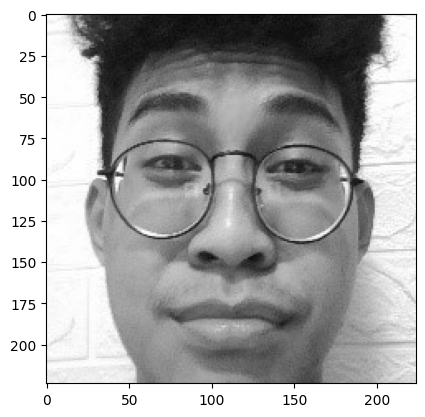

1/1 [==============================] - 0s 150ms/step
Nama File:  2117051019_IMG20231001213627.jpg
Prediksi 101:  2117051019
Prediksi 50:  2117051019
Probabilitas 101:  0.9939071536064148
Probabilitas 50:  0.7922523617744446




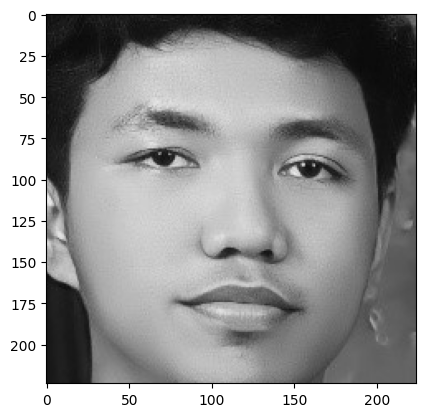

1/1 [==============================] - 0s 145ms/step
Nama File:  2117051027_1692264277882.jpg
Prediksi 101:  2157051006
Prediksi 50:  2017051006
Probabilitas 101:  0.3895828127861023
Probabilitas 50:  0.9242598414421082




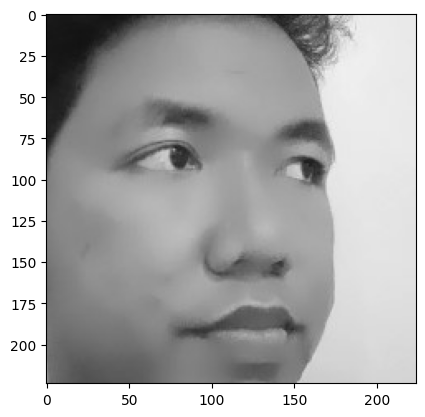

1/1 [==============================] - 0s 143ms/step
Nama File:  2117051027_IMG_20231001_202439_455.jpg
Prediksi 101:  2117051027
Prediksi 50:  2117051027
Probabilitas 101:  0.9871312975883484
Probabilitas 50:  0.9671896696090698




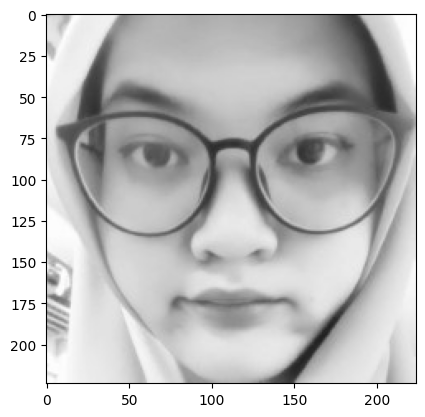

1/1 [==============================] - 0s 148ms/step
Nama File:  2117051043_IMG_20230928_170046_029.jpg
Prediksi 101:  2117051068
Prediksi 50:  2117051043
Probabilitas 101:  0.5662223696708679
Probabilitas 50:  0.3229770064353943




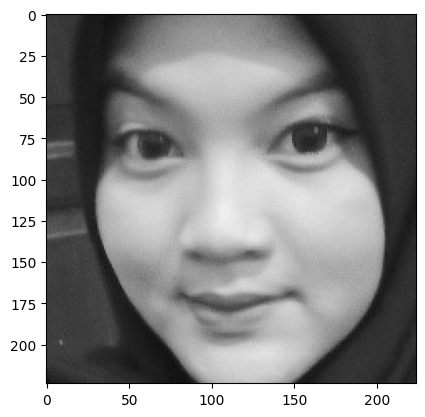

1/1 [==============================] - 0s 141ms/step
Nama File:  2117051043_IMG_20231003_131723.jpg
Prediksi 101:  2117051009
Prediksi 50:  2117051043
Probabilitas 101:  0.9133965373039246
Probabilitas 50:  0.9824366569519043




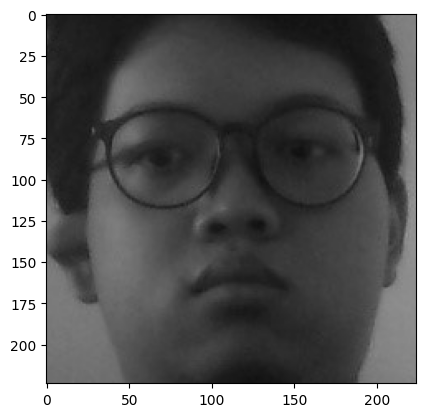

1/1 [==============================] - 0s 138ms/step
Nama File:  2117051048_WIN_20231003_13_41_33_Pro.jpg
Prediksi 101:  2117051048
Prediksi 50:  2117051048
Probabilitas 101:  0.9945629239082336
Probabilitas 50:  0.9996343851089478




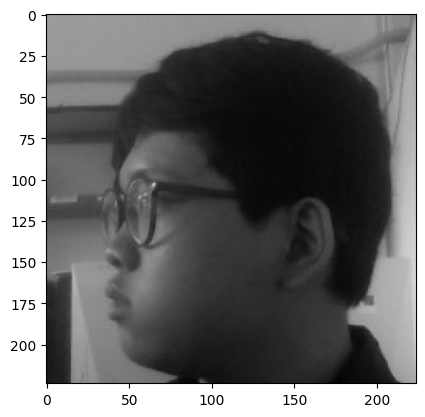

1/1 [==============================] - 0s 160ms/step
Nama File:  2117051048_WIN_20231003_13_43_48_Pro.jpg
Prediksi 101:  2117051048
Prediksi 50:  2117051048
Probabilitas 101:  0.9886441230773926
Probabilitas 50:  0.9846405982971191




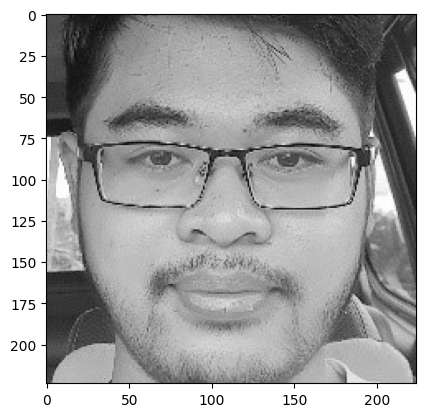

1/1 [==============================] - 0s 139ms/step
Nama File:  2117051050_20220127_133705.jpg
Prediksi 101:  2117051050
Prediksi 50:  2117051050
Probabilitas 101:  0.9762876629829407
Probabilitas 50:  0.9947035908699036




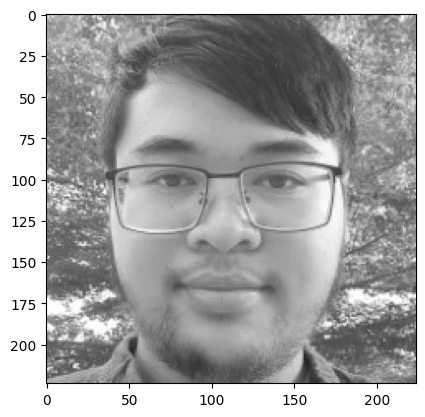

1/1 [==============================] - 0s 132ms/step
Nama File:  2117051050_20230412_165034.jpg
Prediksi 101:  2117051070
Prediksi 50:  2017051017
Probabilitas 101:  0.42490124702453613
Probabilitas 50:  0.7925610542297363




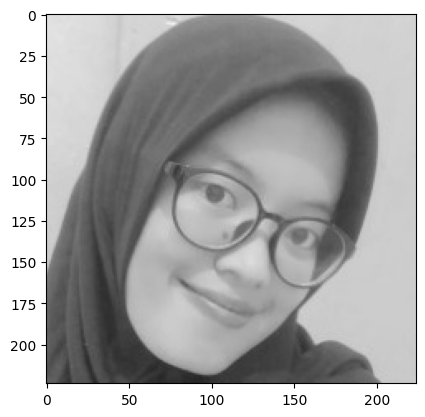

1/1 [==============================] - 0s 158ms/step
Nama File:  2117051068_IMG_20230504_183904_956.jpg
Prediksi 101:  2117051068
Prediksi 50:  2117051068
Probabilitas 101:  0.44035911560058594
Probabilitas 50:  0.468138724565506




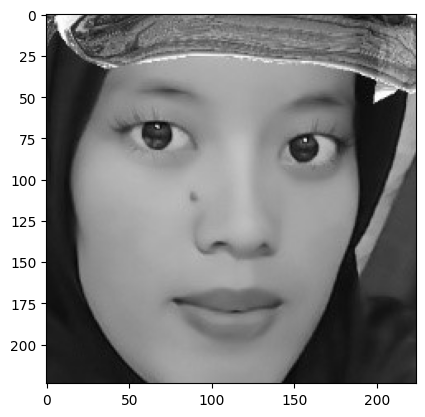

1/1 [==============================] - 0s 142ms/step
Nama File:  2117051068_WhatsApp Image 2023-11-25 at 22-08-45.jpeg
Prediksi 101:  2117051027
Prediksi 50:  2017051051
Probabilitas 101:  0.7209733128547668
Probabilitas 50:  0.6066367626190186




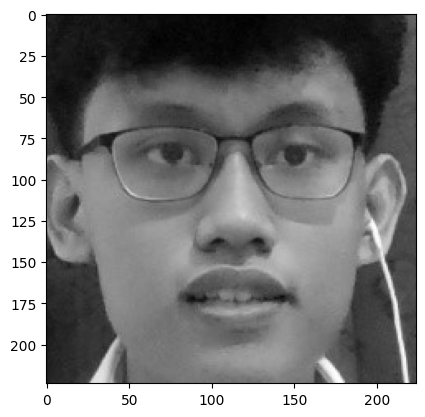

1/1 [==============================] - 0s 154ms/step
Nama File:  2117051070_1699896644499.jpg
Prediksi 101:  2117051070
Prediksi 50:  2117051070
Probabilitas 101:  0.5575225949287415
Probabilitas 50:  0.9916301369667053




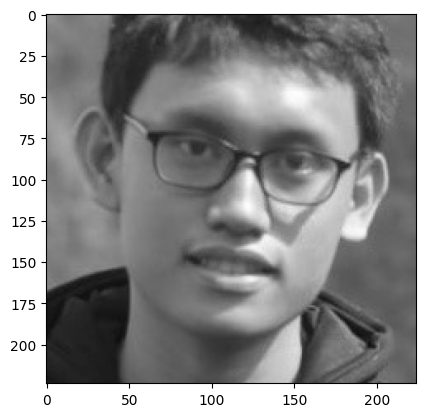

1/1 [==============================] - 0s 139ms/step
Nama File:  2117051070_IMG-20220304-WA0038.jpg
Prediksi 101:  2017051061
Prediksi 50:  2157051006
Probabilitas 101:  0.590956449508667
Probabilitas 50:  0.6122087240219116




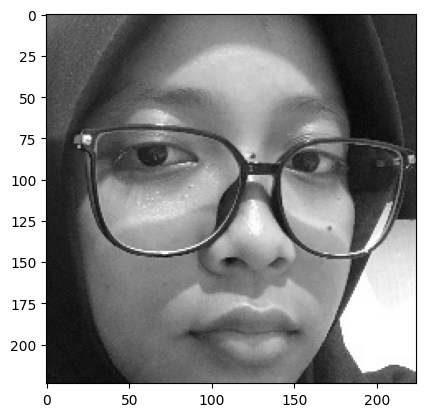

1/1 [==============================] - 0s 140ms/step
Nama File:  2117051095_IMG_9236.jpg
Prediksi 101:  2117051095
Prediksi 50:  2117051050
Probabilitas 101:  0.3083914518356323
Probabilitas 50:  0.705288290977478




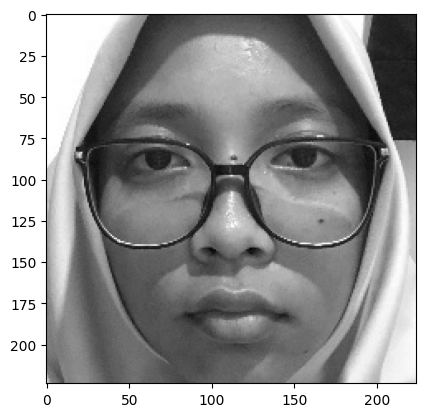

1/1 [==============================] - 0s 129ms/step
Nama File:  2117051095_IMG_9242.jpg
Prediksi 101:  2117051019
Prediksi 50:  2117051095
Probabilitas 101:  0.7768731117248535
Probabilitas 50:  0.9300054311752319




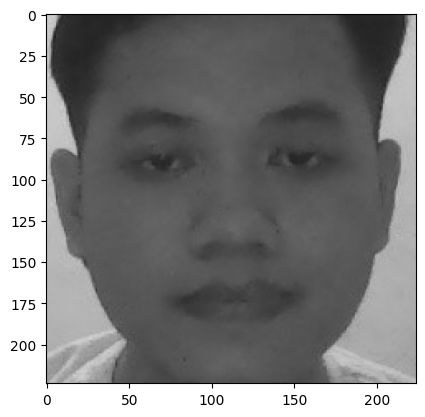

1/1 [==============================] - 0s 142ms/step
Nama File:  2157051001_WIN_20231002_21_48_20_Pro.jpg
Prediksi 101:  2157051001
Prediksi 50:  2157051001
Probabilitas 101:  0.9991627931594849
Probabilitas 50:  0.999796450138092




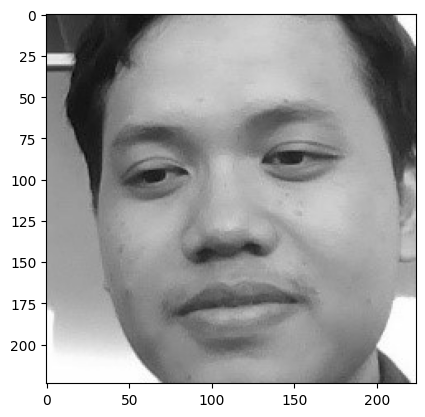

1/1 [==============================] - 0s 173ms/step
Nama File:  2157051001_WIN_20231113_13_50_35_Pro (2).jpg
Prediksi 101:  2007051040
Prediksi 50:  2007051040
Probabilitas 101:  0.6011219620704651
Probabilitas 50:  0.5868526697158813




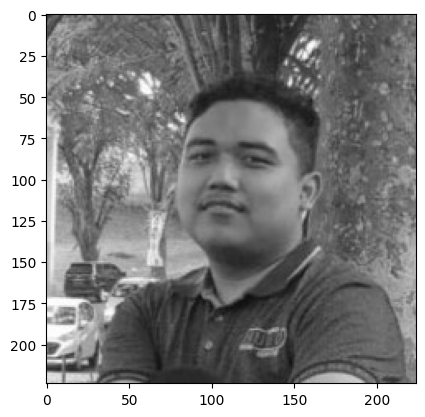

1/1 [==============================] - 0s 140ms/step
Nama File:  2157051006_2157051006_Muhammad Fadhilah Ramadhani_17.jpg
Prediksi 101:  2117051070
Prediksi 50:  2117051070
Probabilitas 101:  0.3985871970653534
Probabilitas 50:  0.9309263229370117




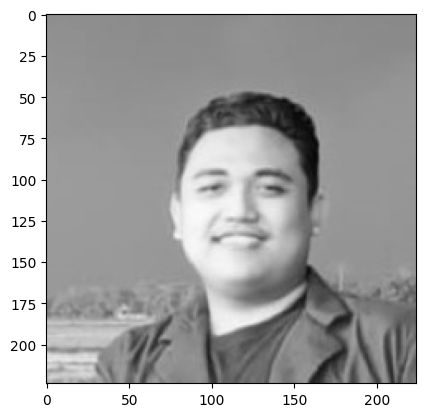

1/1 [==============================] - 0s 167ms/step
Nama File:  2157051006_2157051006_Muhammad Fadhilah Ramadhani_18.jpg
Prediksi 101:  2017051078
Prediksi 50:  2017051078
Probabilitas 101:  0.5562703609466553
Probabilitas 50:  0.9769078493118286


Jumlah prediksi benar 50:  24
Jumlah prediksi salah 50:  16
Jumlah prediksi benar 101:  24
Jumlah prediksi salah 101:  16


In [19]:
conf_resnet50 = np.zeros(shape=(num_classes, num_classes))
conf_resnet101 = np.zeros(shape=(num_classes, num_classes))
labels = train_gen.class_names
count_true_50 = 0
count_false_50 = 0
count_true_101 = 0
count_false_101 = 0
fact_arr = []
predicted_101 = []
predicted_50 = []
for image in os.listdir(testing_path):
  fact = image.split('_')[0]
  fact_arr.append(fact)
  image_path = os.path.join(testing_path, image)

  img = load_img(image_path, target_size=(img_height, img_width))

  # tf.keras.applications.resnetS.preprocess_input(img)

  plt.imshow(img)
  plt.show()

  X = img_to_array(img)

  X = np.expand_dims(X, axis=0)

  images = np.vstack([X])
  # images = tf.keras.applications.resnet50.preprocess_input(images)

  predict_resnet101 = model_resnet101.predict(images)
  predict_resnet50 = model_resnet50.predict(images)

  predicted_class_resnet101 = np.argmax(predict_resnet101, axis=1)[0]
  predicted_class_resnet50 = np.argmax(predict_resnet50, axis=1)[0]

  confidential101 = max(predict_resnet101.tolist()[0])
  confidential50 = max(predict_resnet50.tolist()[0])

  # if confidential101 <= 0.3:
  #   predictions_resnet101 = 'unknown'
  # else:
  predictions_resnet101 = labels[predicted_class_resnet101]

  # if confidential50 <= 0.3:
  #   predictions_resnet50 = 'unknown'
  # else:
  predictions_resnet50 = labels[predicted_class_resnet50]
  
  conf_resnet50[class_dict[fact]][class_dict[predictions_resnet50]] += 1
  conf_resnet101[class_dict[fact]][class_dict[predictions_resnet101]] += 1
  
  predicted_101.append(predictions_resnet101)
  predicted_50.append(predictions_resnet50)

  if predictions_resnet50 == fact:
    count_true_50 += 1
  else:
    count_false_50 += 1

  if predictions_resnet101 == fact:
    count_true_101 += 1
  else:
    count_false_101 += 1

  print('Nama File: ', image)
  print('Prediksi 101: ', predictions_resnet101)
  print('Prediksi 50: ', predictions_resnet50)
  print('Probabilitas 101: ', confidential101)
  print('Probabilitas 50: ', confidential50)

  print('\n')


conf_resnet50 = conf_resnet50.astype(int)
conf_resnet101 = conf_resnet101.astype(int)
print("Jumlah prediksi benar 50: ", count_true_50)
print("Jumlah prediksi salah 50: ", count_false_50)
print("Jumlah prediksi benar 101: ", count_true_101)
print("Jumlah prediksi salah 101: ", count_false_101)

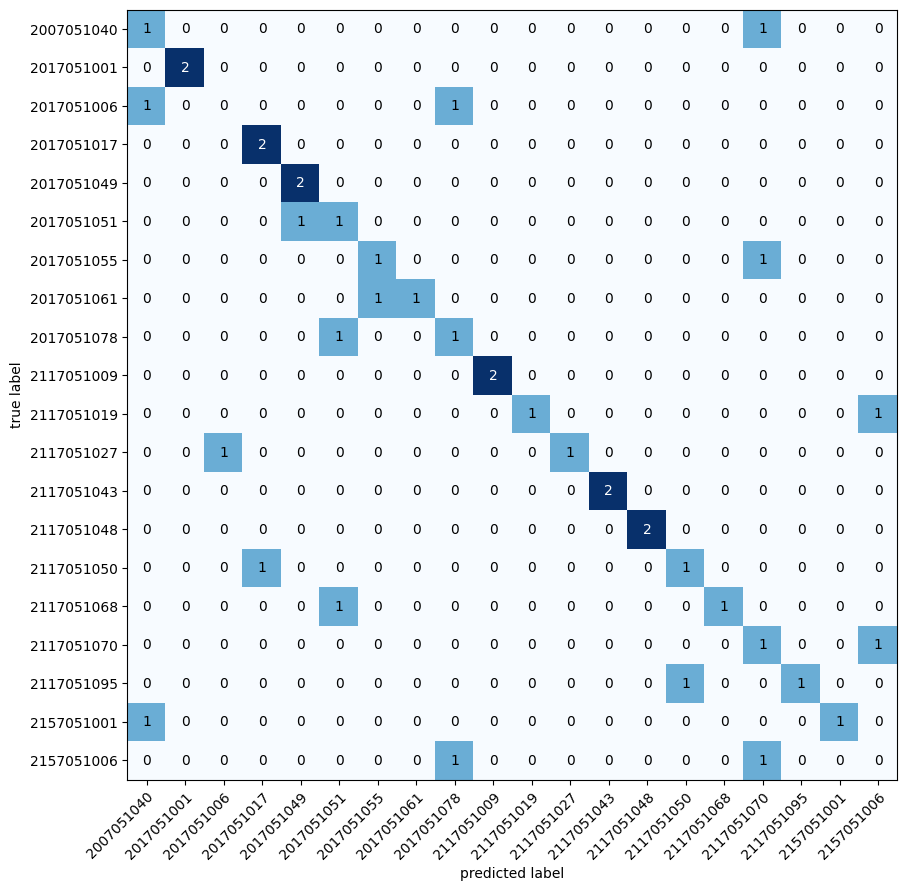

In [20]:
from mlxtend.plotting import plot_confusion_matrix


fig, ax = plot_confusion_matrix(
    conf_mat=conf_resnet50,
    colorbar=False,
    show_absolute=True,
    class_names=class_names,
    figsize=(10, 10)
)

plt.show()

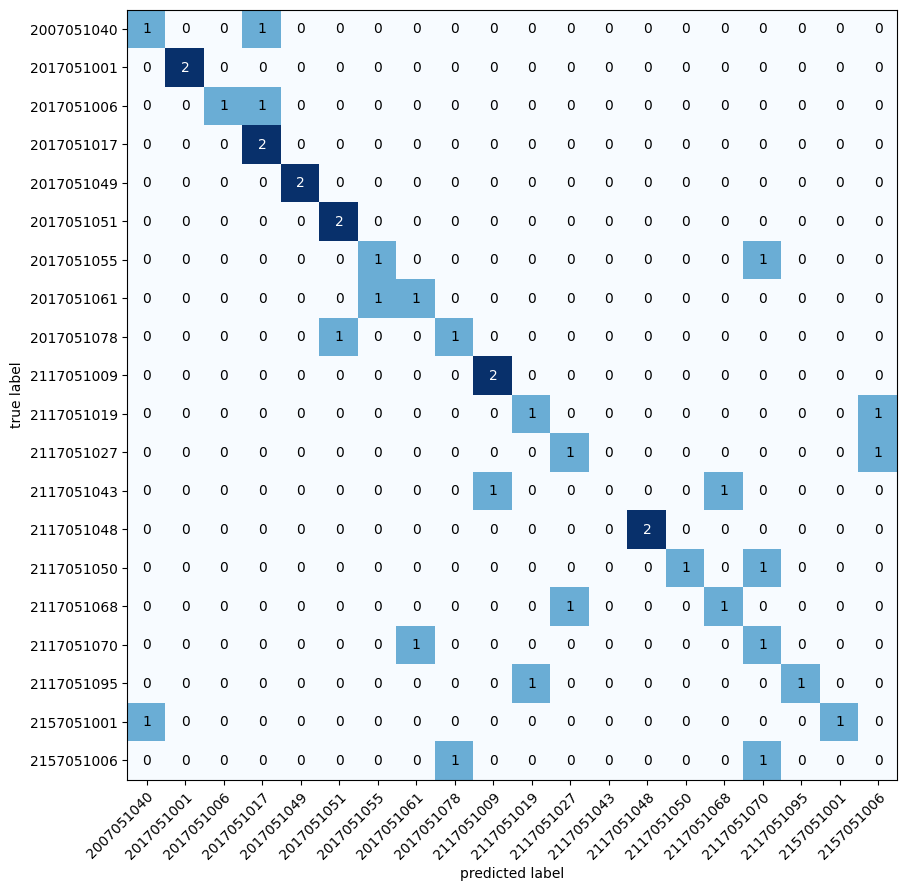

In [25]:
fig, ax = plot_confusion_matrix(
    conf_mat=conf_resnet101,
    colorbar=False,
    show_absolute=True,
    class_names=class_names,
    figsize=(10, 10)
)

plt.show()

In [22]:


print(metrics.classification_report(fact_arr, predicted_50, target_names=train_gen.class_names))

              precision    recall  f1-score   support

  2007051040       0.33      0.50      0.40         2
  2017051001       1.00      1.00      1.00         2
  2017051006       0.00      0.00      0.00         2
  2017051017       0.67      1.00      0.80         2
  2017051049       0.67      1.00      0.80         2
  2017051051       0.33      0.50      0.40         2
  2017051055       0.50      0.50      0.50         2
  2017051061       1.00      0.50      0.67         2
  2017051078       0.33      0.50      0.40         2
  2117051009       1.00      1.00      1.00         2
  2117051019       1.00      0.50      0.67         2
  2117051027       1.00      0.50      0.67         2
  2117051043       1.00      1.00      1.00         2
  2117051048       1.00      1.00      1.00         2
  2117051050       0.50      0.50      0.50         2
  2117051068       1.00      0.50      0.67         2
  2117051070       0.25      0.50      0.33         2
  2117051095       1.00    

In [23]:
print(metrics.classification_report(
    fact_arr, predicted_101, target_names=train_gen.class_names))

              precision    recall  f1-score   support

  2007051040       0.50      0.50      0.50         2
  2017051001       1.00      1.00      1.00         2
  2017051006       1.00      0.50      0.67         2
  2017051017       0.50      1.00      0.67         2
  2017051049       1.00      1.00      1.00         2
  2017051051       0.67      1.00      0.80         2
  2017051055       0.50      0.50      0.50         2
  2017051061       0.50      0.50      0.50         2
  2017051078       0.50      0.50      0.50         2
  2117051009       0.67      1.00      0.80         2
  2117051019       0.50      0.50      0.50         2
  2117051027       0.50      0.50      0.50         2
  2117051043       0.00      0.00      0.00         2
  2117051048       1.00      1.00      1.00         2
  2117051050       1.00      0.50      0.67         2
  2117051068       0.50      0.50      0.50         2
  2117051070       0.25      0.50      0.33         2
  2117051095       1.00    

c:\Users\ervan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ervan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ervan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,